<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_14/blob/main/Reto___Entrega1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad Semanal -- 7 Regresiones y K means**

### **Maestría en Inteligencia Artificial Aplicada**
### **Curso: Ciencia y Analítica de DAtos**
### **Tecnológico de Monterrey**
### **Prof María de la Paz Rico Fernández**

### **Equipo 14**

### **Nombre de los estudiantes**: 
- **Alejandro García Hernández - A01793812**
- **Francisco Javier Morales Jimenez - A01794339**


#Exploración de la base de aguas subterraneas

Limpieza de base de datos.

- Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):
 - Identificando tendencias centrales promedio, media y mediana de los datos. 
 - Identificar medidas de dispersión, máximo, mínimo .
 - Identificar medidas de posición no centrales , los cuartiles , outliers.   
 - Identificar correlaciones.
 - Preparar los datos 
- Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.
- Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 348 kB/s 
     |████████████████████████████████| 1.0 MB 2.5 MB/s 
     |████████████████████████████████| 1.7 MB 37.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 58.0 MB/s 
     |████████████████████████████████| 6.3 MB 43.1 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=5312e298a3fe0ed66057971ee276bdcb53ca8140e069c24187b2c7d2b5067269
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3e31dd5c24ccbc9af2da34f2d20a39492e5289c94fd60429b07df05c168afbef
  Stored in directory: /root/.c

In [ ]:
#librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

from shapely.geometry import Point


In [ ]:
#se descargan los datos y se observan los primeros 3 regiustros
path = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-algaher0805/main/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
df = pd.read_csv(path,encoding='latin-1')

df.head(3)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI


In [ ]:
#Obtenemos información general del tipo de datos y valores perdidos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Observamos que en general los valores faltantes son pocos a excepción de la variable SDT_mg/L que de hecho no contiene información y también CONTAMINANTES que tiene alrededor de 40% de datos faltantes, sin embargo, en esta última tiene sentido que haya valores vacios lo cuál significa que no existe ningún contaminante (se reemplazan los missing por "sin"). Por lo anterior, Se elimana la variable SDT_mg/L ya que no aporta información. 

Por otro lado, si bien existen diferentes indicadores para la calidad del agua, para el análisis del presente trabajo se utilizará solo 3 variables para intentar clasificar la calidad del agua, estas variables son ALC_mg/L,CONDUCT_mS/cm y COLI_FEC_NMP/100_mL, por lo que el resto de las variables de calidad se eliminarán. 
Finalmente, se eliminan las variables de ubicación que no aportan información (clave y sitio).

In [ ]:
df = df [["ORGANISMO_DE_CUENCA","ESTADO","MUNICIPIO","ACUIFERO","SUBTIPO","LONGITUD","LATITUD","PERIODO","ALC_mg/L","CONDUCT_mS/cm","COLI_FEC_NMP/100_mL","CALIDAD_COLI_FEC","SEMAFORO","CONTAMINANTES",
         "CUMPLE_CON_ALC","CUMPLE_CON_COND","CUMPLE_CON_SDT_ra","CUMPLE_CON_SDT_salin","CUMPLE_CON_FLUO","CUMPLE_CON_DUR","CUMPLE_CON_CF","CUMPLE_CON_NO3","CUMPLE_CON_AS","CUMPLE_CON_CD",
         "CUMPLE_CON_CR","CUMPLE_CON_HG","CUMPLE_CON_PB","CUMPLE_CON_MN","CUMPLE_CON_FE"]]

df = df.fillna({'CONTAMINANTES': 'SIN'})
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058 entries, 0 to 1067
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORGANISMO_DE_CUENCA   1058 non-null   object 
 1   ESTADO                1058 non-null   object 
 2   MUNICIPIO             1058 non-null   object 
 3   ACUIFERO              1058 non-null   object 
 4   SUBTIPO               1058 non-null   object 
 5   LONGITUD              1058 non-null   float64
 6   LATITUD               1058 non-null   float64
 7   PERIODO               1058 non-null   int64  
 8   ALC_mg/L              1058 non-null   float64
 9   CONDUCT_mS/cm         1058 non-null   float64
 10  COLI_FEC_NMP/100_mL   1058 non-null   object 
 11  CALIDAD_COLI_FEC      1058 non-null   object 
 12  SEMAFORO              1058 non-null   object 
 13  CONTAMINANTES         1058 non-null   object 
 14  CUMPLE_CON_ALC        1058 non-null   object 
 15  CUMPLE_CON_COND      

In [ ]:
#Observamos que el tipo de la varibale COLI_FEC_NMP/100_mL es object ya que contiene algunos valores con el signo "<", por lo que se sustituye ese valor por 1 y se cambia el tipo de datos
df['COLI_FEC_NMP/100_mL'] = df['COLI_FEC_NMP/100_mL'].replace("<1.1","1").astype('float64')
#df['COLI_FEC_NMP/100_mL'] = df['COLI_FEC_NMP/100_mL'].astype('float64')

In [ ]:
df.nunique()

ORGANISMO_DE_CUENCA       13
ESTADO                    32
MUNICIPIO                448
ACUIFERO                 272
SUBTIPO                    8
LONGITUD                1056
LATITUD                 1057
PERIODO                    1
ALC_mg/L                 810
CONDUCT_mS/cm            798
COLI_FEC_NMP/100_mL      124
CALIDAD_COLI_FEC           5
SEMAFORO                   3
CONTAMINANTES            126
CUMPLE_CON_ALC             2
CUMPLE_CON_COND            2
CUMPLE_CON_SDT_ra          3
CUMPLE_CON_SDT_salin       3
CUMPLE_CON_FLUO            2
CUMPLE_CON_DUR             3
CUMPLE_CON_CF              2
CUMPLE_CON_NO3             3
CUMPLE_CON_AS              2
CUMPLE_CON_CD              2
CUMPLE_CON_CR              2
CUMPLE_CON_HG              2
CUMPLE_CON_PB              2
CUMPLE_CON_MN              2
CUMPLE_CON_FE              2
dtype: int64

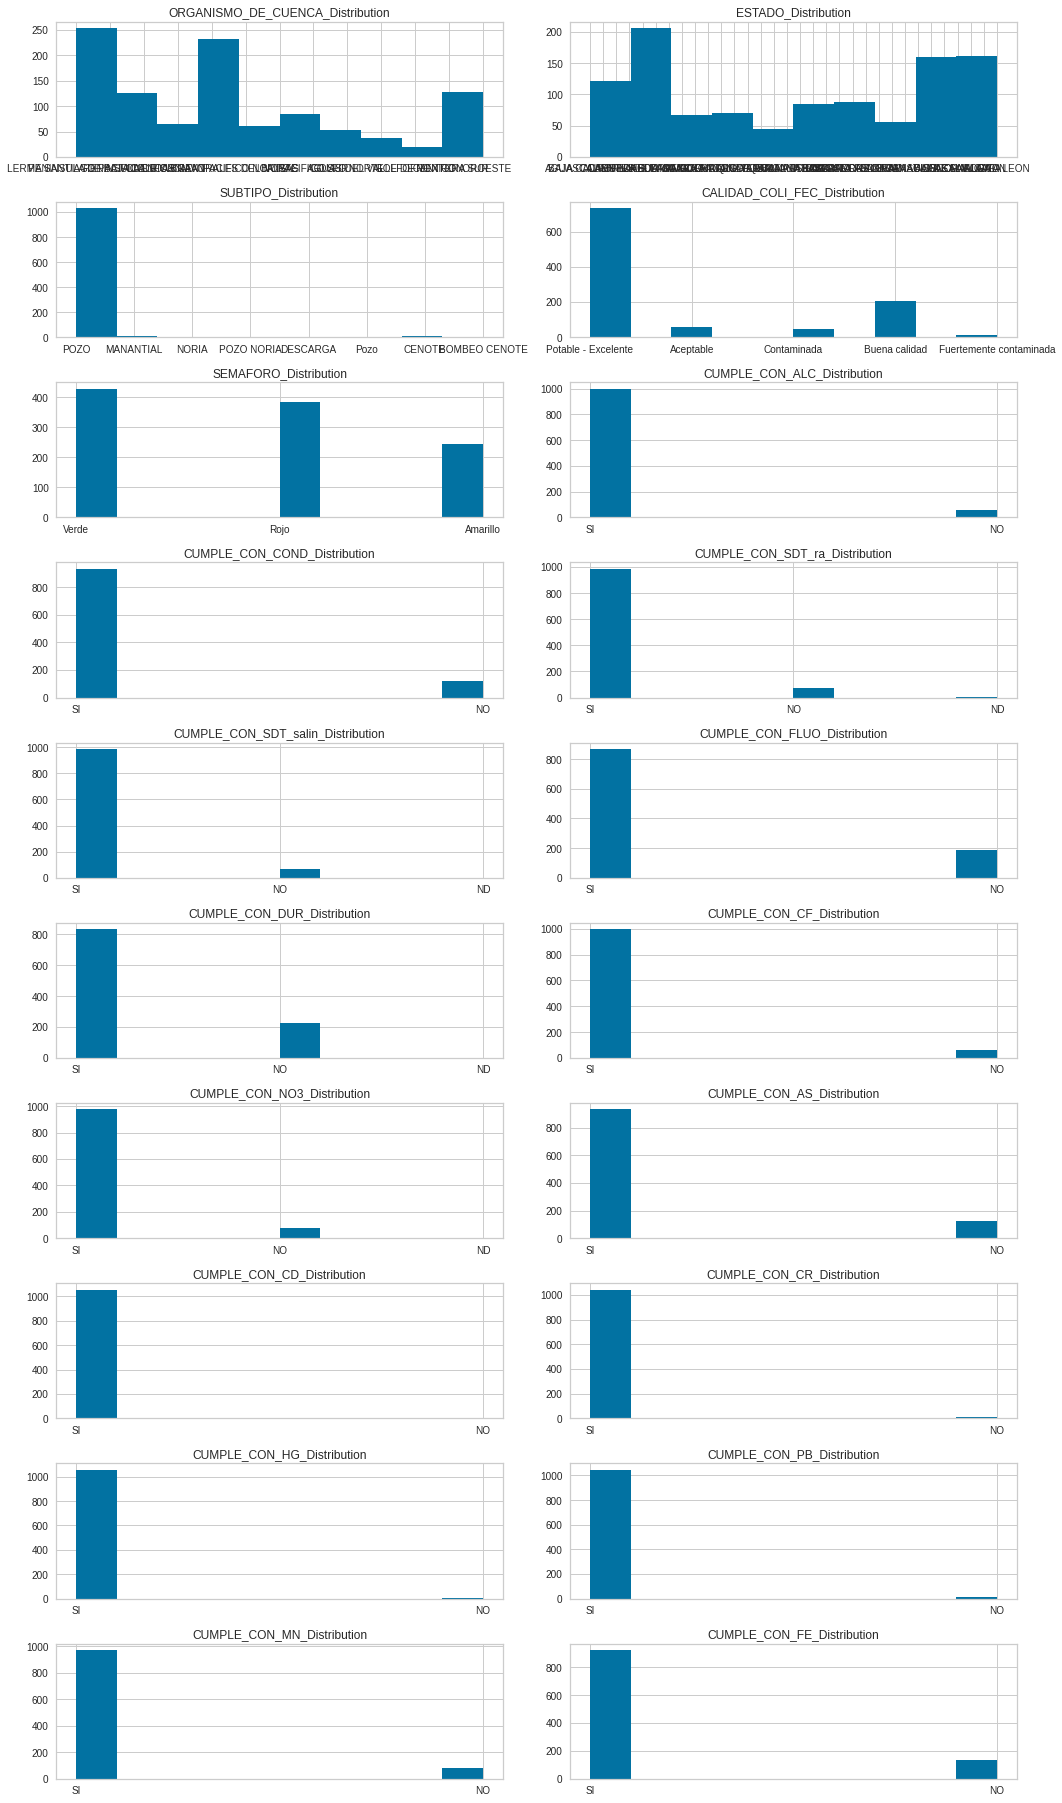

In [ ]:
# Crea gráficos de distribución de las variables categoricas o binarias

def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(15, 50))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(ax=ax)  # parametros de  hist
        ax.set_title(var_name + "_Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

categoricas = ["ORGANISMO_DE_CUENCA","ESTADO","SUBTIPO","CALIDAD_COLI_FEC","SEMAFORO","CUMPLE_CON_ALC","CUMPLE_CON_COND","CUMPLE_CON_SDT_ra","CUMPLE_CON_SDT_salin",
"CUMPLE_CON_FLUO","CUMPLE_CON_DUR","CUMPLE_CON_CF","CUMPLE_CON_NO3","CUMPLE_CON_AS","CUMPLE_CON_CD","CUMPLE_CON_CR","CUMPLE_CON_HG","CUMPLE_CON_PB","CUMPLE_CON_MN","CUMPLE_CON_FE"]

draw_histograms(df, categoricas, 20, 2)

Como se observa, algunas categorias contenidas en estas variables parecen ser menores al 5% del total de los datos, para tener una mayor certeza se obtienen los porcentajes de cada una de estas categorias

In [ ]:
#Observamos que existen valores ND que igualmente representan una cantidad pequeña de datos por lo que se eliminan
df = df.replace("ND",np.nan)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 0 to 1067
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORGANISMO_DE_CUENCA   1054 non-null   object 
 1   ESTADO                1054 non-null   object 
 2   MUNICIPIO             1054 non-null   object 
 3   ACUIFERO              1054 non-null   object 
 4   SUBTIPO               1054 non-null   object 
 5   LONGITUD              1054 non-null   float64
 6   LATITUD               1054 non-null   float64
 7   PERIODO               1054 non-null   int64  
 8   ALC_mg/L              1054 non-null   float64
 9   CONDUCT_mS/cm         1054 non-null   float64
 10  COLI_FEC_NMP/100_mL   1054 non-null   float64
 11  CALIDAD_COLI_FEC      1054 non-null   object 
 12  SEMAFORO              1054 non-null   object 
 13  CONTAMINANTES         1054 non-null   object 
 14  CUMPLE_CON_ALC        1054 non-null   object 
 15  CUMPLE_CON_COND      

In [ ]:
for i in categoricas:
  print(df[i].value_counts()/df.shape[0])

CUENCAS CENTRALES DEL NORTE     0.219165
LERMA SANTIAGO PACIFICO         0.157495
PENINSULA DE YUCATAN            0.118596
NOROESTE                        0.088235
PENINSULA DE BAJA CALIFORNIA    0.081594
BALSAS                          0.064516
RIO BRAVO                       0.061670
PACIFICO NORTE                  0.056926
GOLFO NORTE                     0.050285
AGUAS DEL VALLE DE MEXICO       0.035104
FRONTERA SUR                    0.032258
GOLFO CENTRO                    0.018975
PACIFICO SUR                    0.015180
Name: ORGANISMO_DE_CUENCA, dtype: float64
DURANGO                            0.112903
SONORA                             0.096774
YUCATAN                            0.080645
ZACATECAS                          0.071157
COAHUILA DE ZARAGOZA               0.055977
BAJA CALIFORNIA SUR                0.045541
SAN LUIS POTOSI                    0.044592
GUANAJUATO                         0.037951
HIDALGO                            0.035104
CHIHUAHUA                    

Observamos que hay 3 variables en donde el 99% de los datos se encuentran en una sola categoria por lo que estas también se eliminan de la base.

In [ ]:
df.drop(["CUMPLE_CON_CD","CUMPLE_CON_CR","CUMPLE_CON_HG"], axis = 'columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 0 to 1067
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORGANISMO_DE_CUENCA   1054 non-null   object 
 1   ESTADO                1054 non-null   object 
 2   MUNICIPIO             1054 non-null   object 
 3   ACUIFERO              1054 non-null   object 
 4   SUBTIPO               1054 non-null   object 
 5   LONGITUD              1054 non-null   float64
 6   LATITUD               1054 non-null   float64
 7   PERIODO               1054 non-null   int64  
 8   ALC_mg/L              1054 non-null   float64
 9   CONDUCT_mS/cm         1054 non-null   float64
 10  COLI_FEC_NMP/100_mL   1054 non-null   float64
 11  CALIDAD_COLI_FEC      1054 non-null   object 
 12  SEMAFORO              1054 non-null   object 
 13  CONTAMINANTES         1054 non-null   object 
 14  CUMPLE_CON_ALC        1054 non-null   object 
 15  CUMPLE_CON_COND      

Las variables numéricas solo son 5 LONGITUD, LATITUD, ALC_mg/L, CONDUCT_mS/cm y COLI_FEC_NMP/100_mL, sin embargo, solo tiene sentido obtener las medidas de tendencias centrales promedio, media y mediana de los datos para las últimas 3.

In [ ]:
numericas = ["ALC_mg/L","CONDUCT_mS/cm","COLI_FEC_NMP/100_mL"]
df[numericas].describe()


,ALC_mg/L,CONDUCT_mS/cm,COLI_FEC_NMP/100_mL
count,1054.000000,1054.000000,1054.000000
mean,234.695266,1142.726471,359.665085
std,111.147849,1248.990617,2065.717777
min,26.640000,110.000000,1.000000
25%,164.257500,506.000000,1.000000
50%,215.825000,820.000000,1.000000
75%,292.930000,1328.000000,10.750000
max,1650.000000,18577.000000,24196.000000


Con el resumen de arriba se observa que las 3 variables parecen tener valores atípicos, en el caso de ALC_mg/L la media y la mediana son muy parecidas por lo que el sesgo debe de ser relativamente pequeño, en cambiom en CONDUCT_mS/cm	la media es mayor que la mediana por lo que la distribución está sesgada a la derecha y en el caso de COLI_FEC_NMP/100_mL el sesgo es mucho mayor.

In [ ]:
# función para crear un boxplot y un histograma en la misma escala.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    # Se crean 2 subgráficas

    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")
    # El boxplot se crea e indica el valor de la media de la columna

    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)
    # histograma

    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")
    # Agrega la media al histograma

    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

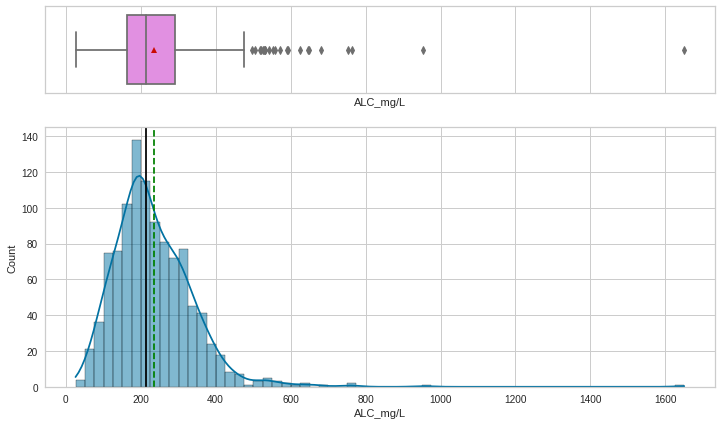

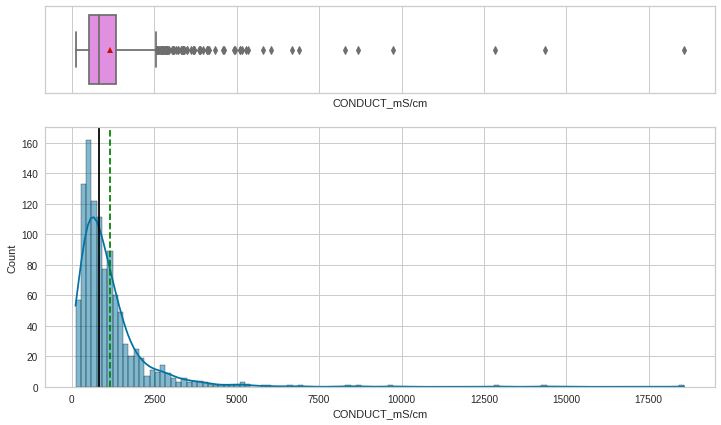

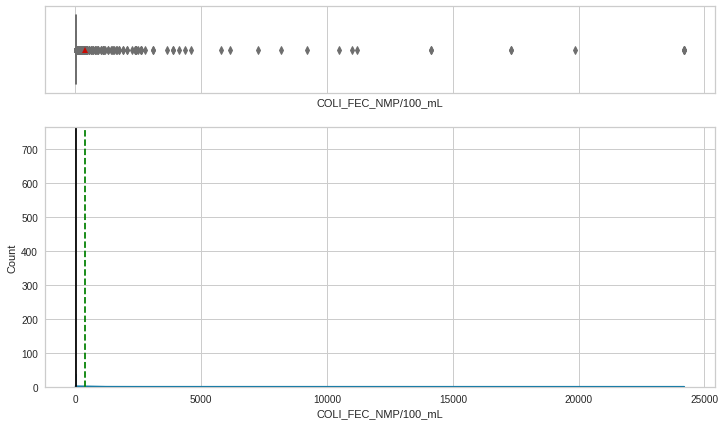

In [ ]:
# Crea gráficos de distribución de las variables numéricas
for n in numericas:
    histogram_boxplot(data=df, feature=n, kde=True)

Con las gráficas anteriores se confirma lo que se había observado previamente con el resumen de indicadores estadísticos de más arriba. Además, para la varibale COLI_FEC_NMP/100_mL la mayoría de los registros tiene el valor de 1 (recordemos que este valor en realidad es <1.1) por lo que puede ser un inconveniente al momento de realizar los clusters, por lo que se omitirá de las variables para realizar el análisis de clusters

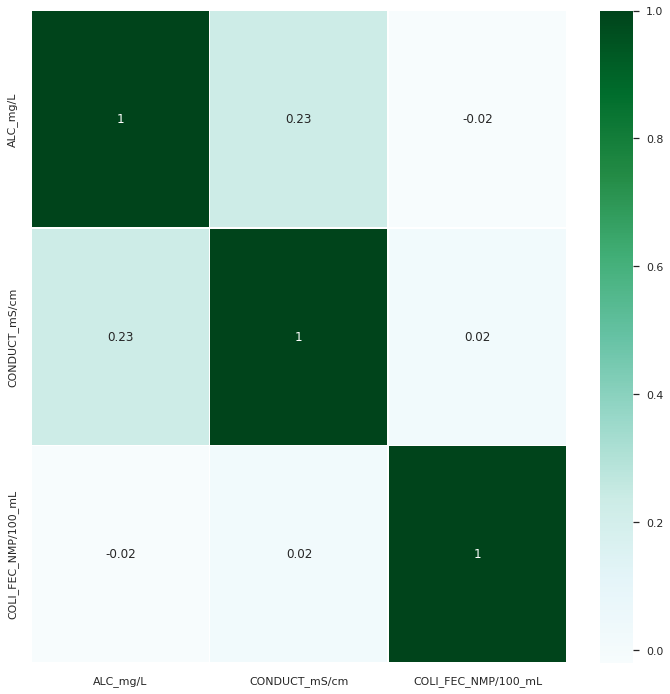

In [ ]:
#Creamos un heatmap para conocer si existen variables correlacionadas

sns.set(rc={'figure.figsize':(12,12)}) 
sns.heatmap(round(df[numericas].corr(),2), annot = True, cmap= 'BuGn', linewidths= 0.5)
plt.show()

No se observa ninguna correlación relevante entre estas varibales. 

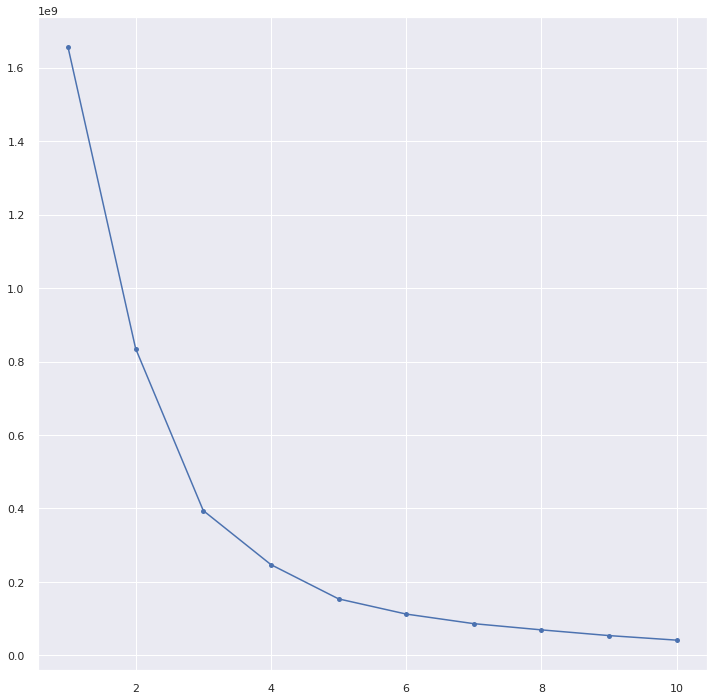

In [ ]:
#se crea la base para trabajar los clusters, no se escalarán los datos
df_clusters = df[["ALC_mg/L","CONDUCT_mS/cm","LATITUD","LONGITUD"]]

#Se grafican las inercias de cada cluster con el objetivo de encontrar el "codo" para seleccionar el número adecuado de clusters
clusters = range(1,11)
inercias = []
for i in clusters:
  km = KMeans(n_clusters = i)
  km.fit(df_clusters)
  inercias.append(km.inertia_)
          
plt.plot(clusters, inercias, "bo-", markersize=5)

Con la gráfica de codo podemos ver que el número óptimo de clusters está entre 2 y 3, por lo que se observan algunas métricas adicionales para tomar un decisión.

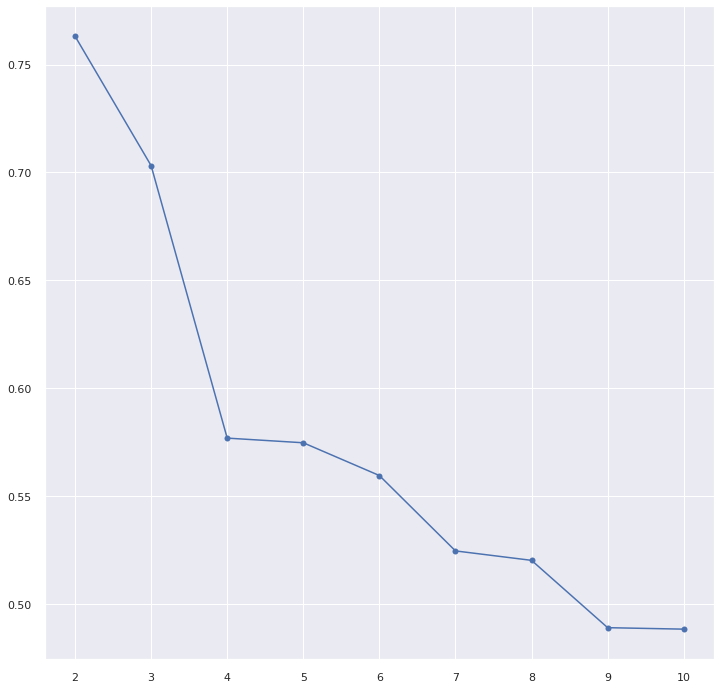

In [ ]:
# silhouette_score nos ayuda para medir que tan poblados y bien separados están los clusters 
lst_silhouette = []
for k in range(2,11):
    cl_sil = KMeans(n_clusters=k)
    cl_sil.fit(df_clusters)
    lst_silhouette.append(silhouette_score(df_clusters,cl_sil.predict(df_clusters)))

plt.plot(range(2,11),lst_silhouette,marker='o')

El indicador silhouette_score muestra que el valor óptimo de cluster es 2 aunque el valor de está métrica para 3 clusters también es bueno.

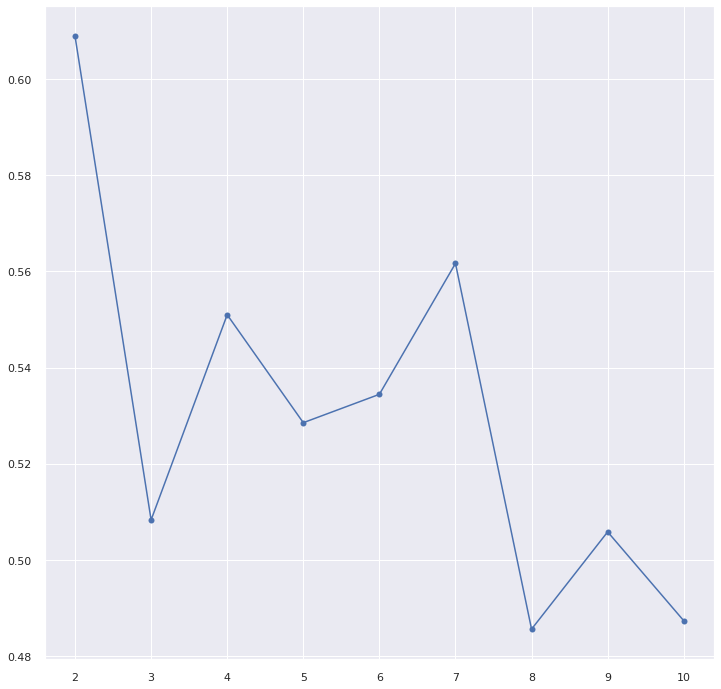

In [ ]:
# el índice Davies-Bouldin es una métricaque muestra la relación entre la dispersión del clúster y la separación del clúster, entre más bajo sea su valor el agrupamiento es mejor.
lst_dbscore=[]
for k in range(2,11):
    cl_db = KMeans(n_clusters=k)
    cl_db.fit(df_clusters)
    lst_dbscore.append(davies_bouldin_score(df_clusters,cl_db.predict(df_clusters)))

plt.plot(range(2,11),lst_dbscore,marker='o')

Con el índice Davies-Bouldin parece que el número óptimo de clusters es de hecho 8 o 10, sin embargo usar demasiados clusters nos puede llevar al sobre-entrenamiento, además el valor para 3 clusters es bueno.

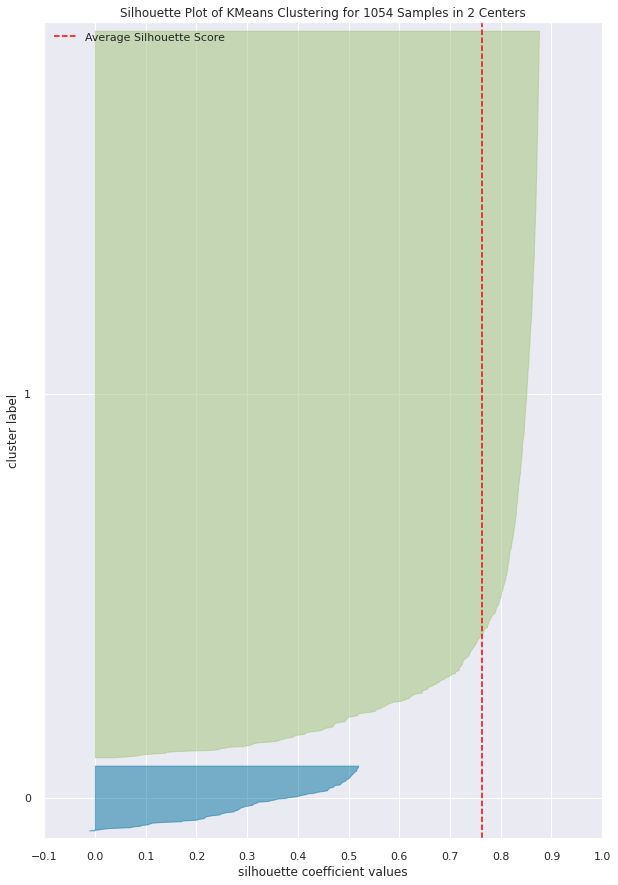

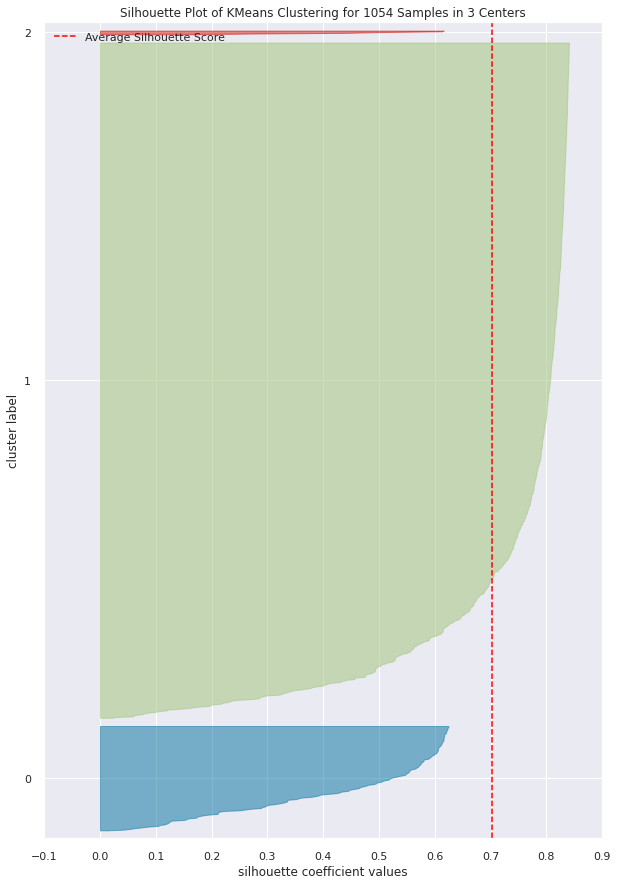

In [ ]:
#Finalmente podemos graficar solo los clusters candidatos y verificar el valor individual de silhouette_score
for j,i in enumerate([2, 3]):
    fig, ax = plt.subplots(figsize=(10,15))
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)

    visualizer = SilhouetteVisualizer(km,ax=ax, colors='yellowbrick',)
    
    visualizer.fit(df_clusters)
    visualizer.show()

Finalmente, observa que el valor de silhouette_score para, si bien hay clusters con valores por debajo de la media, cada uno de estos cluster en general es mayor cuando utilizamos 3 clusters.

In [ ]:
#Se entrena el modelo utilizando 3 clusters y se guardan los centros
km = KMeans(n_clusters = 3)
km = km.fit(df_clusters)

centros = km.cluster_centers_

In [ ]:
#Se transforma nuestro dataframe en coordenadas
df["Coordenadas"] = list(zip(df.LONGITUD, df.LATITUD))
df["Coordenadas"] = df["Coordenadas"].apply(Point)
df['cluster'] = km.labels_

gdf = gpd.GeoDataFrame(df, geometry="Coordenadas")
gdf.head()

,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,...,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,Coordenadas,cluster
0,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,940.0,...,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.02210 22.20887),1
1,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,608.0,...,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.20075 21.99958),1
2,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,532.0,...,NO,SI,SI,SI,NO,SI,SI,SI,POINT (-102.28801 22.36685),1
3,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,686.0,...,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.29449 22.18435),1
4,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,1841.0,...,SI,SI,SI,NO,SI,SI,SI,SI,POINT (-110.24480 23.45138),1


In [ ]:
#Obtenemos el mapa
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


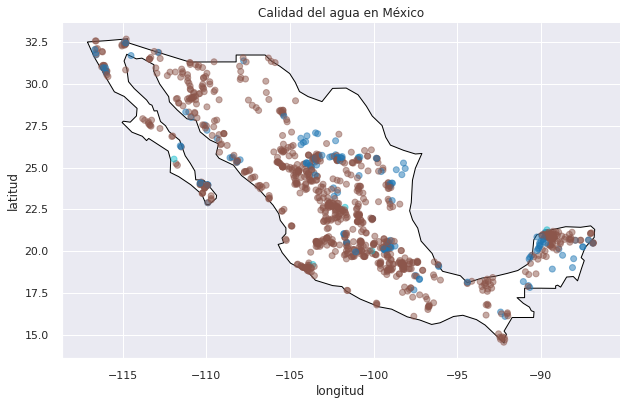

In [ ]:
#Se genera el gráfico
fig, gax = plt.subplots(figsize=(10,10))

#obtenemos el mapa y ubicamos a los dos almacenes
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, column="cluster", alpha = 0.5, categorical=True)

#plt.legend(['cluster 1', 'cluster 2', 'cluster 3']);
# label=str(area)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Calidad del agua en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Basado en el análisis de cluster no parece haber relación entre la calidad del agua y su ubicación geográfica. Para corroborar este resultado podemos simplemente graficar el semáforo de calidad. 

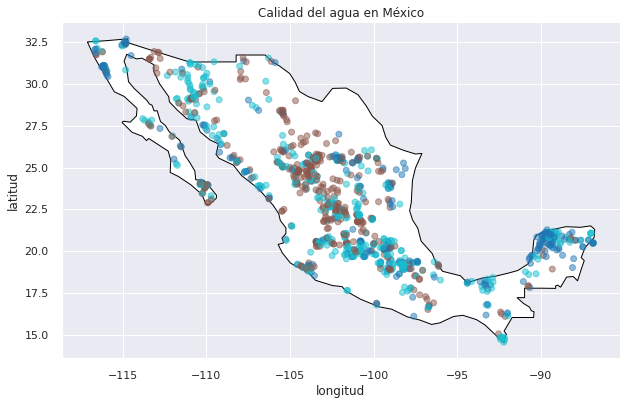

In [ ]:
#Se genera el gráfico
fig, gax = plt.subplots(figsize=(10,10))

#obtenemos el mapa y ubicamos a los dos almacenes
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, column="SEMAFORO", alpha = 0.5, categorical=True)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Calidad del agua en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Con el mapa anterior se confirma el resultado obtenido por los clusters.

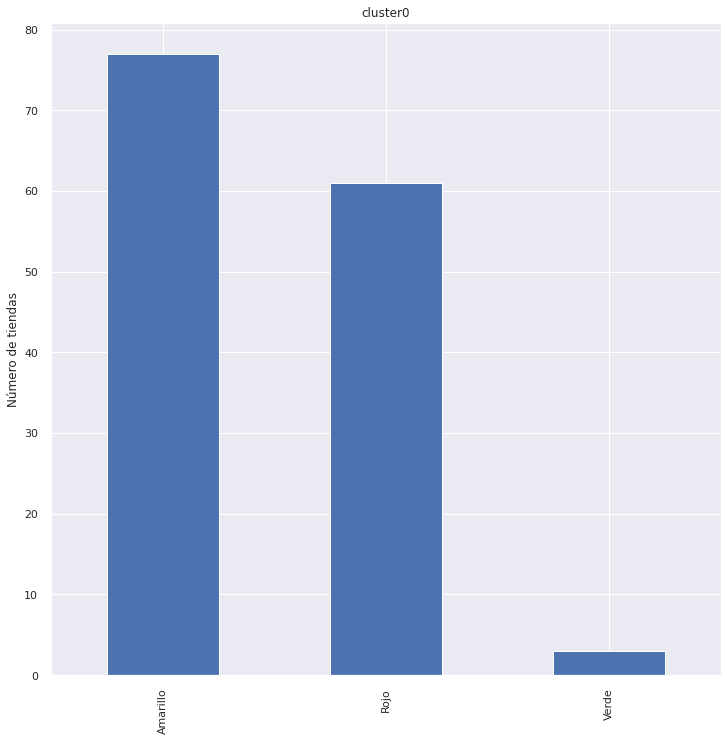

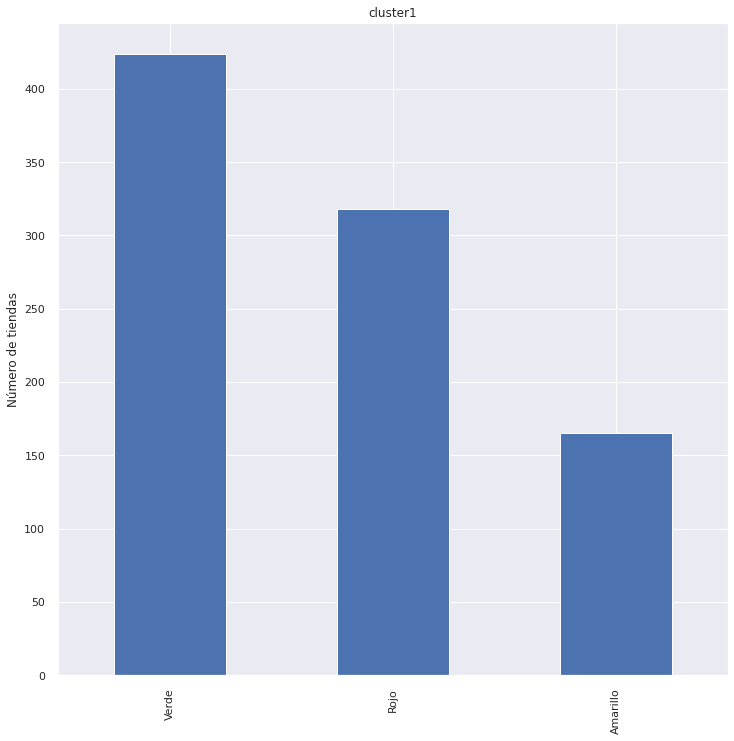

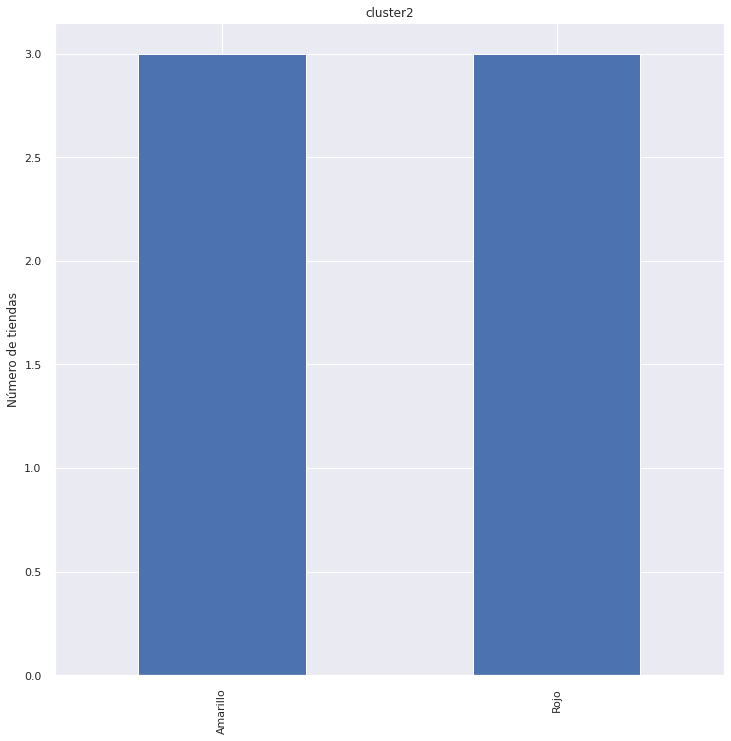

In [ ]:
#Para saber si en cada cluster predomina algún color de semáforo

for i in range(0,3):
  plt.title("cluster"+str(i))
  plt.ylabel('Número de tiendas')
  df["SEMAFORO"][df['cluster']==i].value_counts().plot(kind='bar')

  plt.show()

Como podemos ver, en ninguno de los 3 clusters predomina algún color de semáforo. Finalmente, como validación, se realizó el mismo ejercicio pero utilizando únicamente la latitud y longitud para realizar los clusters.

In [ ]:
#se crea la base para trabajar los clusters, no se escalarán los datos
df_clusters2 = df[["LATITUD","LONGITUD"]]

#Se entrena el modelo utilizando 3 clusters y se guardan los centros
km2 = KMeans(n_clusters = 3)
km2 = km2.fit(df_clusters2)

centros2 = km2.cluster_centers_

In [ ]:
#Se transforma nuestro dataframe en coordenadas
df["Coordenadas"] = list(zip(df.LONGITUD, df.LATITUD))
df["Coordenadas"] = df["Coordenadas"].apply(Point)
df['cluster2'] = km2.labels_

gdf2 = gpd.GeoDataFrame(df, geometry="Coordenadas")
gdf2.head()

,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,Coordenadas,cluster,cluster2
0,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,940.0,...,SI,SI,SI,SI,SI,SI,SI,POINT (-102.02210 22.20887),1,0
1,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,608.0,...,SI,SI,SI,SI,SI,SI,SI,POINT (-102.20075 21.99958),1,0
2,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,532.0,...,SI,SI,SI,NO,SI,SI,SI,POINT (-102.28801 22.36685),1,0
3,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,686.0,...,SI,SI,SI,SI,SI,SI,SI,POINT (-102.29449 22.18435),1,0
4,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,1841.0,...,SI,SI,NO,SI,SI,SI,SI,POINT (-110.24480 23.45138),1,2


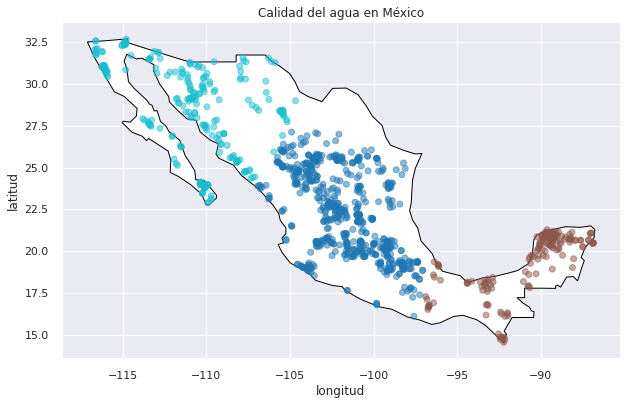

In [ ]:
#Se genera el gráfico
fig, gax = plt.subplots(figsize=(10,10))

#obtenemos el mapa y ubicamos a los dos almacenes
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gdf2.plot(ax=gax, column="cluster2", alpha = 0.5, categorical=True)

#plt.legend(['cluster 1', 'cluster 2', 'cluster 3']);
# label=str(area)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Calidad del agua en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

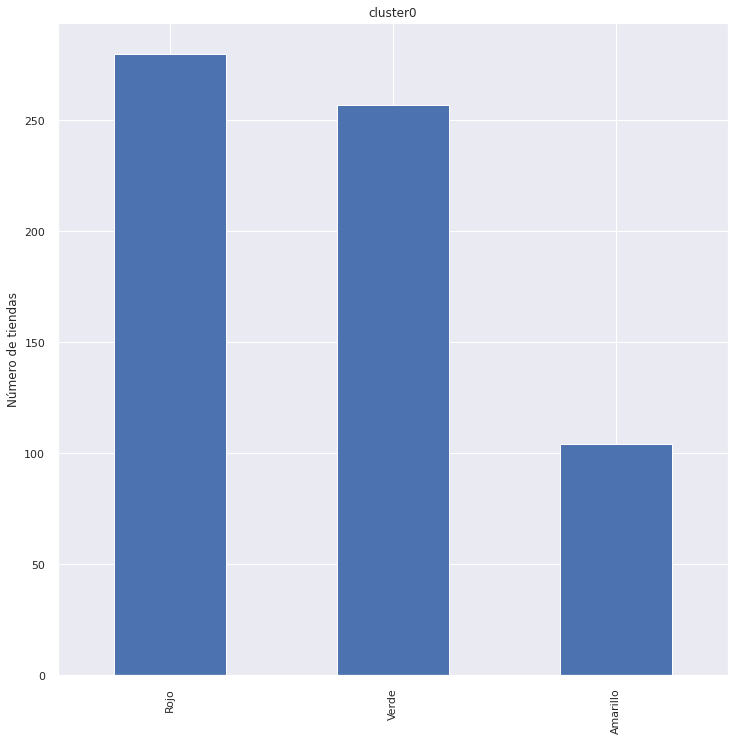

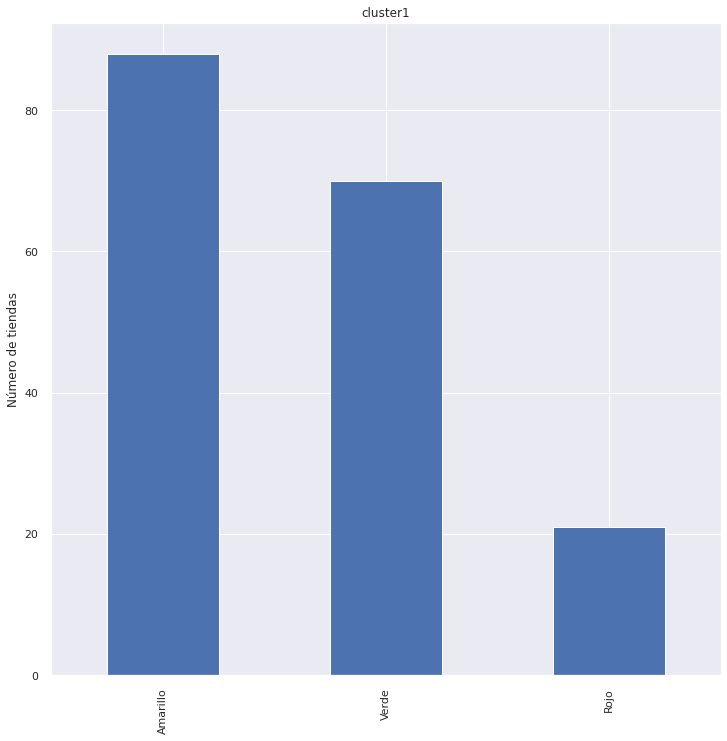

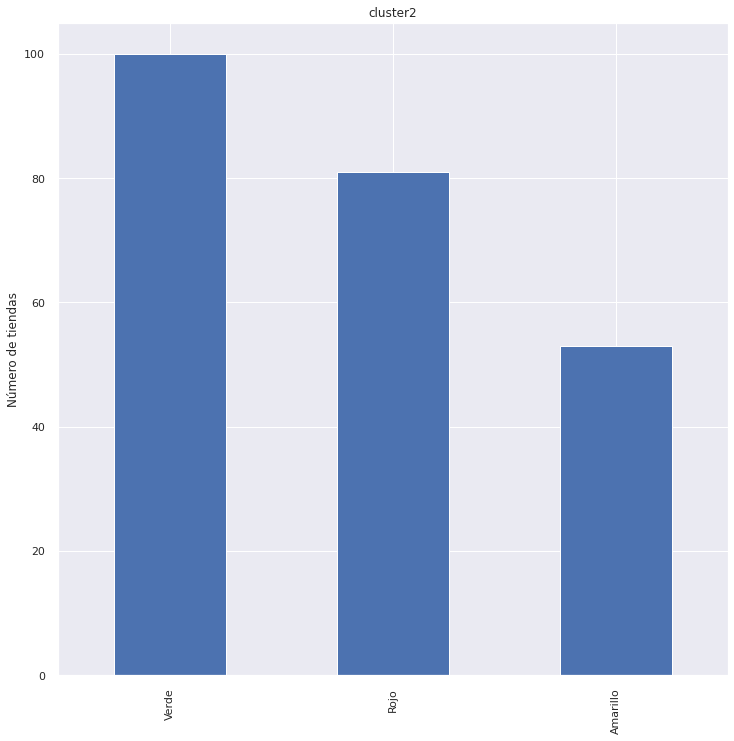

In [ ]:
#Para saber si en cada cluster predomina algún color de semáforo

for i in range(0,3):
  plt.title("cluster"+str(i))
  plt.ylabel('Número de tiendas')
  df["SEMAFORO"][df['cluster2']==i].value_counts().plot(kind='bar')

  plt.show()

Nuevamente se observa que en ningún cluster predomina algún color de semáforo.